# This notebook computes the stacks for all pairs from single sources

In [1]:
import os,random,time,pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.signal.filter import bandpass
from seisgo import noise,utils,plotting
from seisgo.stacking import seisstack as stack
import pygmt as gmt

## Global parameters

In [2]:
dataroot='data_stacking'
comp="ZZ"
raw=os.path.join(dataroot,"MERGED_cascadia_raw")
tnorm=os.path.join(dataroot,"MERGED_cascadia_tnorm")
raw_xz=os.path.join(dataroot,"MERGED_XZ_raw")
tnorm_xz=os.path.join(dataroot,"MERGED_XZ_tnorm")

#
figformat="png"
figdpi=200

dlabels=["Raw","One-bit"]
cmap="seismic"
methods=["tfpws","tfpws-dost"]
method_labels=["tf-PWS-ST","tf-PWS-DOST"]
colors=["k","b","c","y","g","orange","r","m"]
figlabels=["(a)","(b)","(c)","(d)","(e)","(f)","(g)","(h)"]

### XZ pairs from a single virtual source

In [3]:
XZ_source="XZ.A02"
network="XZ"
flist_xz=[utils.get_filelist(raw_xz+"/"+XZ_source,"h5"),
          utils.get_filelist(tnorm_xz+"/"+XZ_source,"h5")]
stack_all_xz=dict()
dist_all_xz=dict()
cputiming=np.ndarray((len(dlabels),len(methods)))
#get general parameters
cdict_temp=noise.extract_corrdata(flist_xz[0][0].replace("\n",""),comp=comp)
cdata0=cdict_temp[list(cdict_temp.keys())[0]][comp]
npts_xz=cdata0.data.shape[1] #get number of points.
maxlag_xz=cdata0.lag
dt_xz=cdata0.dt
stack_all_xz["maxlag"]=maxlag_xz
stack_all_xz["dt"]=dt_xz
stack_all_xz["methods"]=methods
stack_all_xz["labels"]=dlabels
stack_all_xz["source"]=XZ_source
for i,flist in enumerate(flist_xz):
    print(dlabels[i])
    stack_all_xz[dlabels[i]]=np.ndarray((len(methods),len(flist),npts_xz)) #3 dimensional array        
    dist_all_xz[dlabels[i]]=np.ndarray((len(flist)))
    
    for k,m in enumerate(methods):
        t1=time.time()
        for j,f0 in enumerate(flist[:30]):
            f=f0.replace("\n","")
            print(f+"  --> "+str(j))
            cdict=noise.extract_corrdata(f,comp=comp)
            p=list(cdict.keys())[0]
            cdata=cdict[p][comp]
            netsta1 = cdata.net[0]+'.'+cdata.sta[0]#+'.'+c.loc[0]+'.'+c.chan[0]
            netsta2 = cdata.net[1]+'.'+cdata.sta[1]#+'.'+c.loc[1]+'.'+c.chan[1]

            dist_all_xz[dlabels[i]][j]=cdata.dist
        
            ds = stack(cdata.data.copy(),m)
            if netsta2.lower() == XZ_source.lower(): ds=np.flip(ds)
            stack_all_xz[dlabels[i]][k,j,:]=ds
        cputiming[i,k]=time.time()-t1
#
stack_all_xz["cputime"]=cputiming

Raw
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A03.h5  --> 0
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A04.h5  --> 1
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A05.h5  --> 2
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A06.h5  --> 3
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A07.h5  --> 4
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A08.h5  --> 5
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A09.h5  --> 6
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A10.h5  --> 7
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A11.h5  --> 8
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A12.h5  --> 9
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A13.h5  --> 10
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A14.h5  --> 11
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A15.h5  --> 12
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A16.h5  --> 13
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A17.h5  --> 14
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A18.h5  --> 15
data_stacking/MERGED_XZ_raw/XZ.A02/XZ.A02_XZ.A

In [4]:
with open('xcorr_stacks_allpair_'+network+'_tfpws_compare.pk','wb') as xf:
    pickle.dump(stack_all_xz,xf)
    pickle.dump(dist_all_xz,xf)

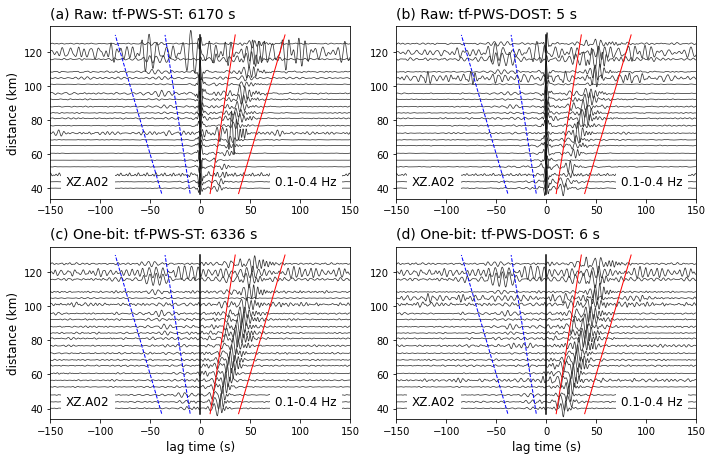

In [26]:
""" 
moveout plot
"""
#UNCOMMENT THESE LINES IF READING FROM FILE.
# infile="xcorr_stacks_allpair_XZ_tfpws_compare_bkp.pk"
# with open(infile,'rb') as xf:
#     stack_all_xz=pickle.load(xf)
#     dist_all_xz=pickle.load(xf)
    
figsize=(10,6.5)
lag=150
scale=[[13,6.5],[5,5]]
savefig=True
freqmin_xz,freqmax_xz=[0.1,.4]#[0.04,0.4]
snr_window_extend_xz=20
maxlag_xz=stack_all_xz["maxlag"]
dt_xz=stack_all_xz["dt"]
if lag>maxlag_xz:raise ValueError('lag excceds maxlag!')
tvec_xz=np.arange(-maxlag_xz,maxlag_xz+0.5*dt_xz,dt_xz)
vmin_xz=2
vmax_xz=3.7
dist_xz=[vmax_xz/freqmin_xz,130]
fig=plt.figure(figsize=figsize,facecolor='w')
# fig.suptitle("Virtual source: "+XZ_source+": "+str(freqmin_xz)+"-"+str(freqmax_xz)+" Hz",fontsize=14)
for i in range(len(dlabels)):
    for j,m in enumerate(method_labels):
        plt.subplot(2,2,j+1+2*i)
        for k in range(stack_all_xz[dlabels[i]].shape[1]):
            if dist_all_xz[dlabels[i]][k] >= dist_xz[0] and dist_all_xz[dlabels[i]][k] <= dist_xz[1]:
                dp = bandpass(stack_all_xz[dlabels[i]][j,k,:],freqmin_xz,freqmax_xz,1/dt_xz,corners=4, zerophase=True)
                plt.plot(tvec_xz,dist_all_xz[dlabels[i]][k]+scale[i][j]*dp/np.max(np.abs(dp)),
                             color=[.2,.2,.2],linewidth=0.75,alpha=1)
        # plot signal window
        plt.plot([snr_window_extend_xz + dist_xz[0]/vmin_xz,snr_window_extend_xz+ dist_xz[1]/vmin_xz],
                 dist_xz,'r',lw=1)
        plt.plot([dist_xz[0]/vmax_xz,dist_xz[1]/vmax_xz],dist_xz,'r',lw=1)
        
        plt.plot([-snr_window_extend_xz - dist_xz[0]/vmin_xz,-snr_window_extend_xz- dist_xz[1]/vmin_xz],
                 dist_xz,'b--',lw=1)
        plt.plot([-dist_xz[0]/vmax_xz,-dist_xz[1]/vmax_xz],dist_xz,'b--',lw=1)
        
        plt.xlim([-lag,lag])
        plt.ylim([dist_xz[0]-3,dist_xz[1]+5])
        if i>0:
            plt.xlabel('lag time (s)',fontsize=12)
        if j==0:
            plt.ylabel('distance (km)',fontsize=12)
        plt.text(-0.9*lag,dist_xz[0]+5,XZ_source,backgroundcolor='w',fontsize=12)
        plt.text(0.5*lag,dist_xz[0]+5,str(freqmin_xz)+"-"+str(freqmax_xz)+" Hz",
                 backgroundcolor='w',fontsize=12)
        plt.title('%s %s: %s: %d s' % (figlabels[j+2*i],dlabels[i],m,cputiming[i,j]),
                        fontsize=14,loc="left",pad=9)
        plt.plot((0,0),dist_xz,'k-')
plt.tight_layout()
if savefig:
    plt.savefig("Figure-X_xcorr_stacks_allpair_moveout_XZ_compare_tfpws_dost.%s"%(figformat),dpi=figdpi)
    plt.close()
else:
    plt.show()